In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Carregamento dos dados
dataset = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
# Convertendo as variáveis categóricas em variáveis dummy menos customerID
dataset_dummies = pd.get_dummies(dataset.drop('customerID', axis=1))

# Dividindo os dados em características e target
X = dataset_dummies.drop(['Churn_Yes', 'Churn_No'], axis=1)  # Características
y = dataset_dummies['Churn_Yes']  # Churn_Yes ja tem 0 e 1

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost

In [4]:
# Configuração do modelo XGBoost
xg_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.5,
    colsample_bytree=0.5,
    objective='binary:logistic',
    random_state=42
)

In [5]:
xg_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [6]:
predictions = xg_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.8041163946061036
              precision    recall  f1-score   support

       False       0.85      0.90      0.87      1036
        True       0.66      0.54      0.60       373

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.80      0.80      1409



# Rede neural

In [7]:
# Define the model
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)), 
    Dropout(0.3), 
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3), 
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3), 
    Dense(1, activation='sigmoid') 
])

# Compile the model
nn_model.compile(optimizer='adam',
              loss= BinaryCrossentropy(from_logits=False), 
              metrics=['accuracy'])

# Print the model summary
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               841728    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

In [8]:
# Convert data types
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

NameError: name 'X_val' is not defined

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ModelCheckpoint('best_model.h5', save_best_only=True, verbose=1)
]

history = nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=callbacks)

Epoch 1/50
159/159 [==============================] - ETA: 0s - loss: 1.4270 - accuracy: 0.7410
Epoch 1: val_loss improved from inf to 0.85029, saving model to best_model.h5
159/159 [==============================] - 3s 11ms/step - loss: 1.4270 - accuracy: 0.7410 - val_loss: 0.8503 - val_accuracy: 0.7908
Epoch 2/50
154/159 [============================>.] - ETA: 0s - loss: 0.7560 - accuracy: 0.7800
Epoch 2: val_loss improved from 0.85029 to 0.61839, saving model to best_model.h5
159/159 [==============================] - 1s 9ms/step - loss: 0.7538 - accuracy: 0.7793 - val_loss: 0.6184 - val_accuracy: 0.7855
Epoch 3/50
156/159 [============================>.] - ETA: 0s - loss: 0.6072 - accuracy: 0.7756
Epoch 3: val_loss improved from 0.61839 to 0.55226, saving model to best_model.h5
159/159 [==============================] - 2s 10ms/step - loss: 0.6077 - accuracy: 0.7763 - val_loss: 0.5523 - val_accuracy: 0.7943
Epoch 4/50
153/159 [===========================>..] - ETA: 0s - loss: 0.546

In [ ]:
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')
test_loss, test_acc = nn_model.evaluate(X_test, y_test)
print('Test Accuracy:', test_acc)

45/45 [==============================] - 0s 5ms/step - loss: 0.4308 - accuracy: 0.8034
Test Accuracy: 0.8034066557884216


In [ ]:
# Classification report
predictions = nn_model.predict(X_test)
predictions = (predictions > 0.5).astype(int)
print(classification_report(y_test, predictions))

45/45 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87      1036
         1.0       0.68      0.49      0.57       373

    accuracy                           0.80      1409
   macro avg       0.76      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



# Ensemble

In [ ]:
# For classification, get probabilities of the positive class
nn_predictions = nn_model.predict(X_test)[:, 0]  # Assuming binary classification and sigmoid activation
xgb_predictions = xg_model.predict_proba(X_test)[:, 1]  # Get probability of the positive class

In [ ]:
# For classification, get probabilities of the positive class
nn_predictions = nn_model.predict(X_test)[:, 0]  # Assuming binary classification and sigmoid activation
xgb_predictions = xg_model.predict_proba(X_test)[:, 1]  # Get probability of the positive class

In [ ]:
final_predictions = (nn_predictions + xgb_predictions) / 2

In [ ]:
# If doing classification, you might need to threshold the averaged predictions
final_class_predictions = (final_predictions > 0.5).astype(int)
print("Ensemble Accuracy:", accuracy_score(y_test, final_class_predictions))

# Dataset desbalanceado

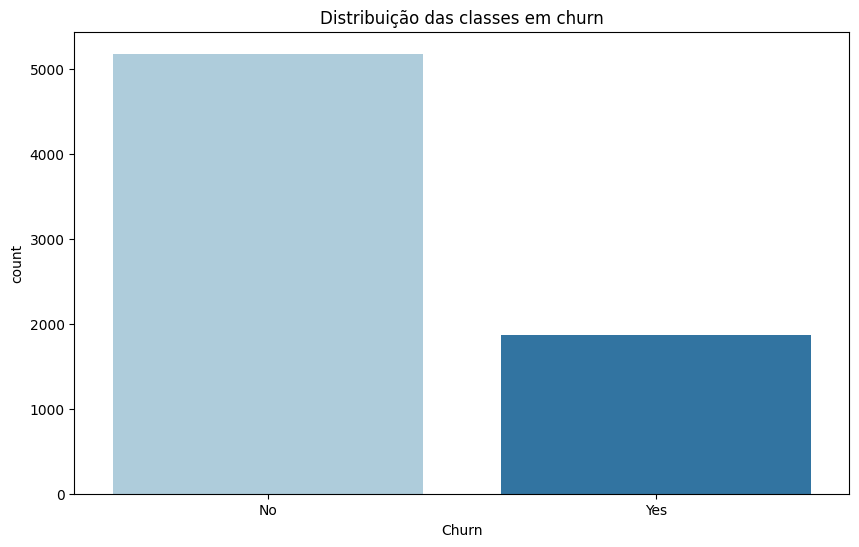

In [ ]:
# Gráfico da Distribuição das classes em churn
plt.figure(figsize=(10, 6))
sns.countplot(x='Churn', data=dataset, palette='Paired', legend=False, hue='Churn')
plt.title('Distribuição das classes em churn')
plt.show()